In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from scipy.optimize import curve_fit

In [2]:
pathData = '../../../data/realData/'
dfTanouchi25 = pd.read_csv(pathData + 'Tanouchi25C.csv')
dfTanouchi37 = pd.read_csv(pathData + 'Tanouchi37C.csv')

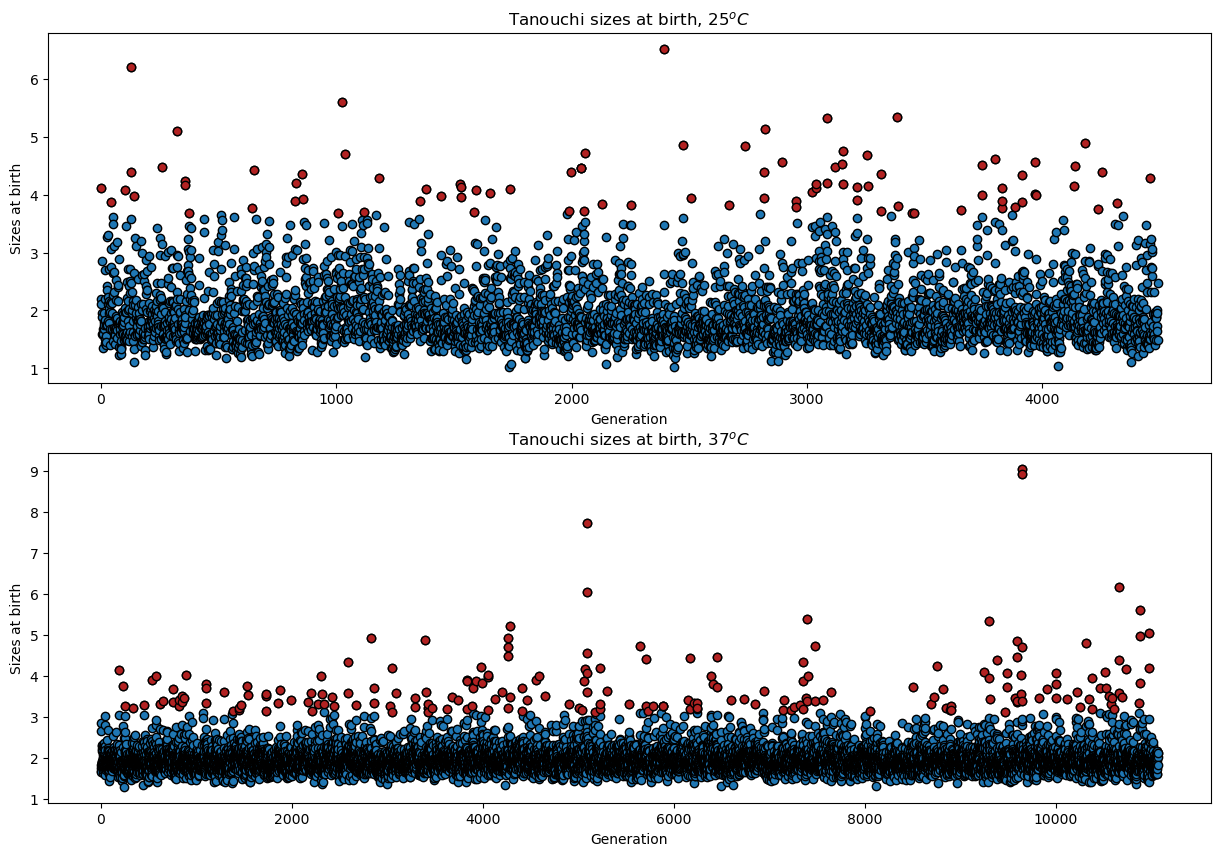

In [3]:
fig, ax_ = plt.subplots(2, 1, figsize=(15, 10))
for df, degrees, ax in zip([dfTanouchi25, dfTanouchi37], [25, 37], ax_.flatten()):
    seizesAtBirth = np.array(df['length_birth'])
    ax.scatter(range(len(df)), seizesAtBirth, edgecolor = 'black')
    zScores = (seizesAtBirth - np.mean(seizesAtBirth)) / np.std(seizesAtBirth)
    idxOut = np.where(np.abs(zScores) > 3)[0]
    ax.scatter(np.arange(len(df))[idxOut], seizesAtBirth[idxOut], color = 'firebrick', edgecolor = 'black')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Sizes at birth')
    ax.set_title(f'Tanouchi sizes at birth, ${degrees}^oC$')
#fig.tight_layout()

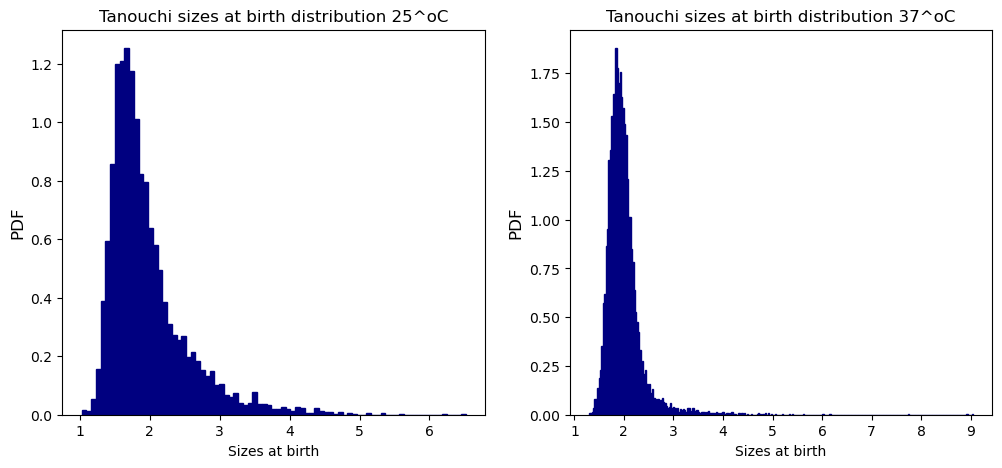

In [4]:
fig, ax_ = plt.subplots(1, 2, figsize=(12, 5))
for df, degrees, ax in zip([dfTanouchi25, dfTanouchi37], [25, 37], ax_.flatten()):
    _, _, _ = ax.hist(df['length_birth'], bins = 'fd', density = True, edgecolor = 'navy', color = 'navy')
    ax.set_xlabel('Sizes at birth')
    ax.set_ylabel('PDF', fontsize = 12)
    ax.set_title(f'Tanouchi sizes at birth distribution {degrees}^oC', fontsize = 12)

In [5]:
def autoCorrelationFunc(t, xi, n_c):
    return t**(-xi) * np.exp(-t/n_c)

Fitted autocorrelation length, 25 degrees: 195.691,
Fitted (2 - eta) 25 degrees: 1.365
Fitted autocorrelation length, 37 degrees: 32.371,
Fitted (2 - eta) 37 degrees: 1.330


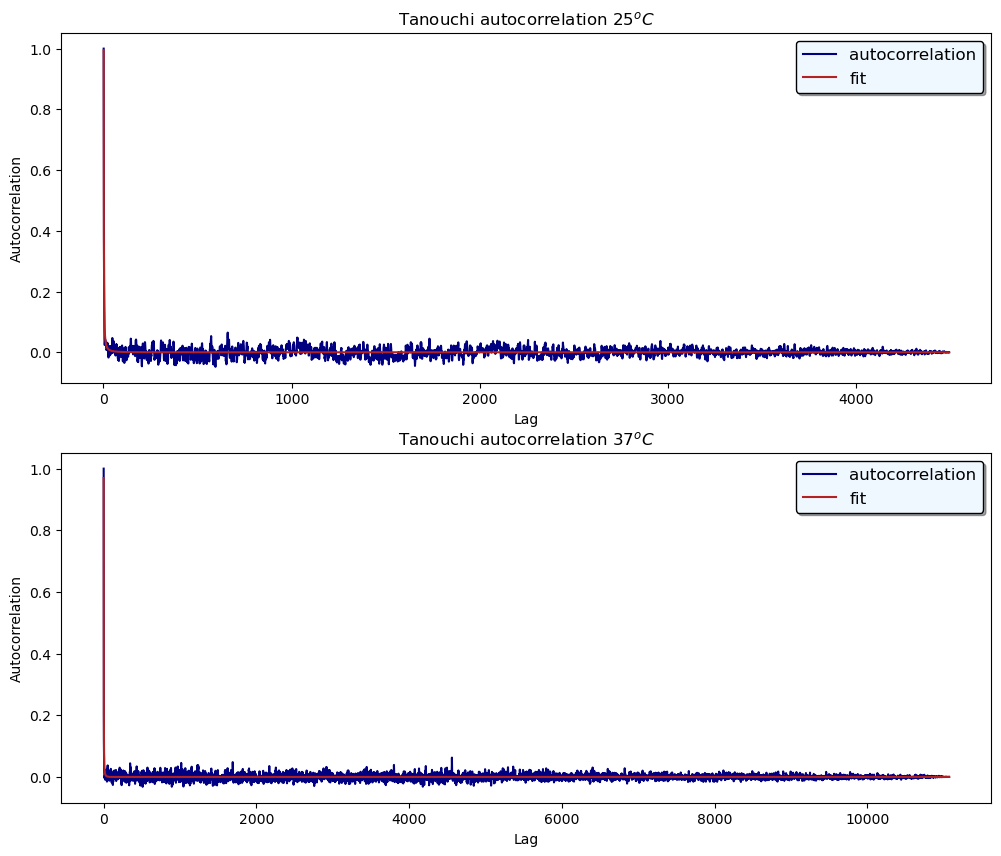

In [6]:
fig, ax_ = plt.subplots(2, 1, figsize=(12, 10))
for df, degrees, ax in zip([dfTanouchi25, dfTanouchi37], [25, 37], ax_.flatten()):    
    autocorrelation = acf(df['length_birth'], nlags = len(df) - 1)
    
    _ = ax.plot(range(1, len(autocorrelation) + 1), autocorrelation, color = 'navy', label = 'autocorrelation')
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    _ = ax.plot(range(1, len(autocorrelation) + 1), autoCorrelationFunc(np.array(list(range(1, len(autocorrelation) + 1))), *popt), color = 'firebrick', label = 'fit')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Tanouchi autocorrelation ${degrees}^oC$')
    _ = ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 12)
    print(f'Fitted autocorrelation length, {degrees} degrees: {popt[1]:.3f},\nFitted (2 - eta) {degrees} degrees: {popt[0]:.3f}')


In [ ]:
print('Mean Size')